# **Experiment 6 | EC69210**
**Code Authors:** Irsh Vijay (21EC39055) and Aditya Raj (21EC39001) \

In [ ]:
# !gdown "1_NAyIx0lJULuVIie-PkauxU4m60F5EFn"
!unzip -q "ISD_Lab_exp6_open.zip" -d .

replace ./ISD_Lab_exp6/Adam — PyTorch main documentation.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

def load_image(path):
    img = torchvision.io.read_image(path)
    img = img.permute(1,2,0)[..., :3]/255.
    return img

image = load_image('image.jpg')
center_crop_size = 512
image = image[image.shape[0] // 2 - center_crop_size//2:image.shape[0] // 2 + center_crop_size//2, image.shape[1] // 2 - center_crop_size//2:image.shape[1] // 2 + center_crop_size//2]

grid = torch.Tensor([[(x, y) for x in range(image.shape[0])] for y in range(image.shape[1])])

def get_ip_op(image, grid):
	ip = [grid[x][y] / 512 for x in range(image.shape[0]) for y in range(image.shape[1])]
	op = [image[x, y] for x in range(image.shape[0]) for y in range(image.shape[1])]
	return torch.stack(ip), torch.stack(op)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_inputs, train_outputs = get_ip_op(image[::2, ::2], grid[::2, ::2])
test_inputs, test_outputs = get_ip_op(image, grid)

train_inputs, train_outputs = train_inputs.to(DEVICE), train_outputs.to(DEVICE)
test_inputs, test_outputs = test_inputs.to(DEVICE), test_outputs.to(DEVICE)

num_epochs = 2000


In [ ]:
class MLP(nn.Module):
	def __init__(self, m=2, n=3):
		super().__init__()
		self.fc1 = nn.Linear(m, 256)
		self.fc2 = nn.Linear(256, 256)
		self.fc3 = nn.Linear(256, 256)
		self.fc4 = nn.Linear(256, n)

	def forward(self, x):
		x = torch.nn.functional.relu(self.fc1(x))
		x = torch.nn.functional.relu(self.fc2(x))
		x = torch.nn.functional.relu(self.fc3(x))
		x = torch.sigmoid(self.fc4(x))
		return x

In [ ]:
class FFMLP(MLP):
	def __init__(self, n=3, d=256, s=10):
		super().__init__(m=2*d, n=n)
		self.B = s * torch.randn((d, 2)).to(DEVICE)

	def forward(self, x):
		x = 2 * torch.pi * x @ self.B.T
		x = torch.cat([torch.sin(x), torch.cos(x)], axis=1)
		return super().forward(x)

In [ ]:
model = MLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

In [ ]:
def psnr(pred, target):
    return -10 * torch.log10(2.*loss_fn(pred, target))

Epoch: 1 | loss: 0.06547731161117554 | train_psnr: 8.828791618347168 | test_psnr: 8.851293563842773
Epoch: 101 | loss: 0.052830200642347336 | train_psnr: 9.76087760925293 | test_psnr: 9.757192611694336
Epoch: 201 | loss: 0.05102964863181114 | train_psnr: 9.911474227905273 | test_psnr: 9.907221794128418
Epoch: 301 | loss: 0.047434836626052856 | train_psnr: 10.228727340698242 | test_psnr: 10.226640701293945
Epoch: 401 | loss: 0.03989153727889061 | train_psnr: 10.980892181396484 | test_psnr: 10.982637405395508
Epoch: 501 | loss: 0.03182689845561981 | train_psnr: 11.961756706237793 | test_psnr: 11.958712577819824
Epoch: 601 | loss: 0.027795424684882164 | train_psnr: 12.549966812133789 | test_psnr: 12.540675163269043
Epoch: 701 | loss: 0.026046833023428917 | train_psnr: 12.832151412963867 | test_psnr: 12.820263862609863
Epoch: 801 | loss: 0.02504057064652443 | train_psnr: 13.00325870513916 | test_psnr: 12.989916801452637
Epoch: 901 | loss: 0.024252813309431076 | train_psnr: 13.1420793533325

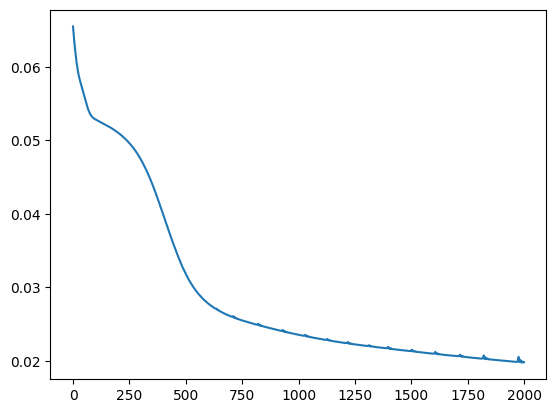

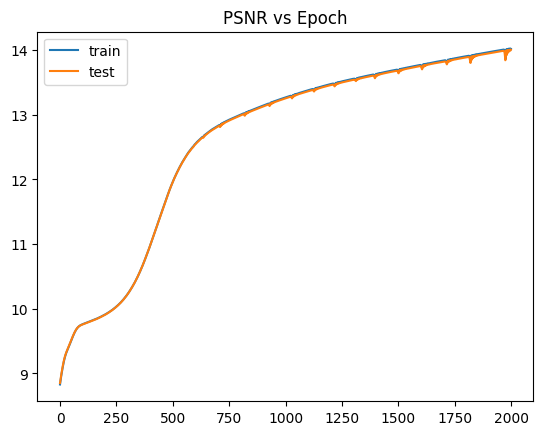

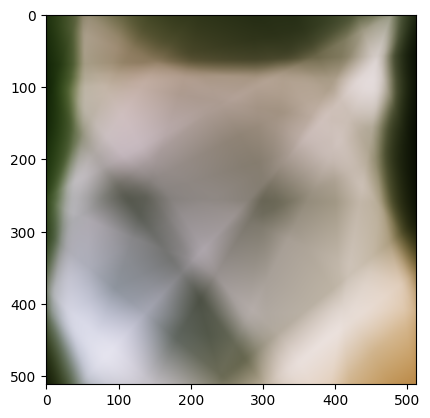

In [ ]:
def train():
	model.train()
	ops = []
	train_psnrs = []
	test_psnrs = []
	losses = []

	for epoch in range(num_epochs):

		optimizer.zero_grad()
		train_preds = model(train_inputs)
		loss = loss_fn(train_outputs, train_preds)

		loss.backward()
		losses.append(loss.item())
		optimizer.step()

		with torch.no_grad():
			train_psnrs.append(psnr(train_preds, train_outputs).cpu().numpy())
			test_preds = model(test_inputs)
			test_psnrs.append(psnr(test_preds, test_outputs).cpu().numpy())
			pred_img = test_preds.reshape(512, 512, 3).cpu().numpy()
			ops.append(pred_img)

		if (epoch)%100==0:
			print(f"Epoch: {epoch+1} | loss: {loss.item()} | train_psnr: {train_psnrs[-1]} | test_psnr: {test_psnrs[-1]}")

	print()
	return ops, train_psnrs, test_psnrs, losses

ops, train_psnrs, test_psnrs, losses = train()

import numpy as np
max_idx = np.argmax(test_psnrs)
best_op = ops[max_idx]

plt.plot(losses)
plt.show()

plt.plot(train_psnrs, label='train')
plt.plot(test_psnrs, label='test')
plt.title('PSNR vs Epoch')
plt.legend()
plt.show()

plt.imshow(best_op)
plt.show()

## FFMLP

In [ ]:
model = FFMLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

Epoch: 1 | loss: 0.06496995687484741 | train_psnr: 8.862573623657227 | test_psnr: 8.879576683044434
Epoch: 101 | loss: 0.011932473629713058 | train_psnr: 16.222396850585938 | test_psnr: 16.28948211669922
Epoch: 201 | loss: 0.0061141992919147015 | train_psnr: 19.12630271911621 | test_psnr: 18.975669860839844
Epoch: 301 | loss: 0.005076739937067032 | train_psnr: 19.93385124206543 | test_psnr: 19.650341033935547
Epoch: 401 | loss: 0.00442111911252141 | train_psnr: 20.534378051757812 | test_psnr: 20.083961486816406
Epoch: 501 | loss: 0.003850321751087904 | train_psnr: 21.134729385375977 | test_psnr: 20.450546264648438
Epoch: 601 | loss: 0.0032921801321208477 | train_psnr: 21.814863204956055 | test_psnr: 20.792518615722656
Epoch: 701 | loss: 0.0027906368486583233 | train_psnr: 22.532669067382812 | test_psnr: 21.08289909362793
Epoch: 801 | loss: 0.002380390651524067 | train_psnr: 23.22321891784668 | test_psnr: 21.305160522460938
Epoch: 901 | loss: 0.0020598105620592833 | train_psnr: 23.85142

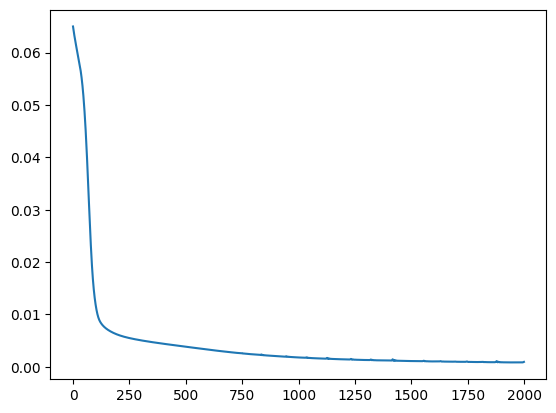

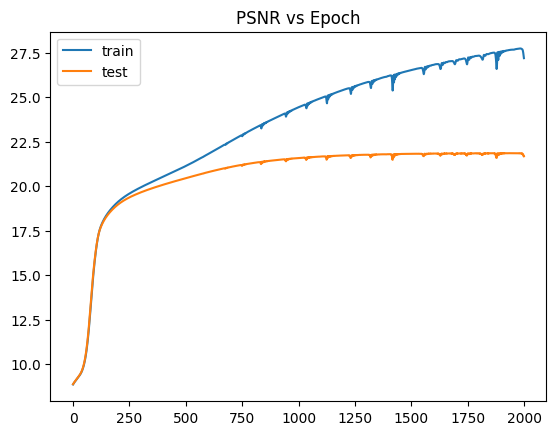

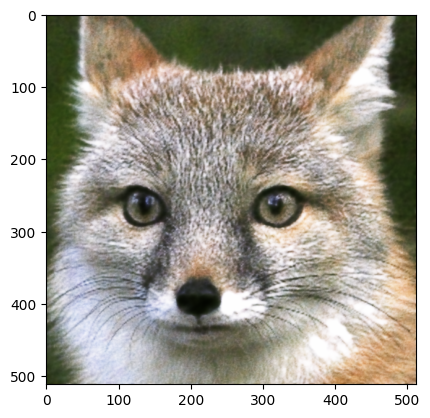

In [ ]:
n_ckpt = 100

def train():
	model.train()
	ops = []
	train_psnrs = []
	test_psnrs = []
	losses = []

	for epoch in range(num_epochs):

		optimizer.zero_grad()
		train_preds = model(train_inputs)
		loss = loss_fn(train_outputs, train_preds)

		loss.backward()
		losses.append(loss.item())
		optimizer.step()

		with torch.no_grad():
			train_psnrs.append(psnr(train_preds, train_outputs).cpu().numpy())
			test_preds = model(test_inputs)
			test_psnrs.append(psnr(test_preds, test_outputs).cpu().numpy())
			pred_img = test_preds.reshape(512, 512, 3).cpu().numpy()

			if (epoch)%n_ckpt==0:
				ops.append(pred_img)
				print(f"Epoch: {epoch+1} | loss: {loss.item()} | train_psnr: {train_psnrs[-1]} | test_psnr: {test_psnrs[-1]}")

	print()
	return ops, train_psnrs, test_psnrs, losses

ops, train_psnrs, test_psnrs, losses = train()

import numpy as np
max_idx = np.argmax(test_psnrs)
best_op = ops[max_idx // n_ckpt]

plt.plot(losses)
plt.show()

plt.plot(train_psnrs, label='train')
plt.plot(test_psnrs, label='test')
plt.title('PSNR vs Epoch')
plt.legend()
plt.show()

plt.imshow(best_op)
plt.show()

Epoch: 1 | loss: 0.06484049558639526 | train_psnr: 8.871237754821777 | test_psnr: 8.902618408203125
Epoch: 101 | loss: 0.021818742156028748 | train_psnr: 13.60140323638916 | test_psnr: 13.618894577026367
Epoch: 201 | loss: 0.012513972818851471 | train_psnr: 16.0157470703125 | test_psnr: 16.00478744506836
Epoch: 301 | loss: 0.010062329471111298 | train_psnr: 16.96271514892578 | test_psnr: 16.933897018432617
Epoch: 401 | loss: 0.009119302034378052 | train_psnr: 17.39008331298828 | test_psnr: 17.34429168701172
Epoch: 501 | loss: 0.008646638132631779 | train_psnr: 17.621227264404297 | test_psnr: 17.572731018066406
Epoch: 601 | loss: 0.00835246592760086 | train_psnr: 17.77155303955078 | test_psnr: 17.725845336914062
Epoch: 701 | loss: 0.008145848289132118 | train_psnr: 17.88033676147461 | test_psnr: 17.83094024658203
Epoch: 801 | loss: 0.007992320694029331 | train_psnr: 17.96297264099121 | test_psnr: 17.911537170410156
Epoch: 901 | loss: 0.007890427485108376 | train_psnr: 18.018695831298828

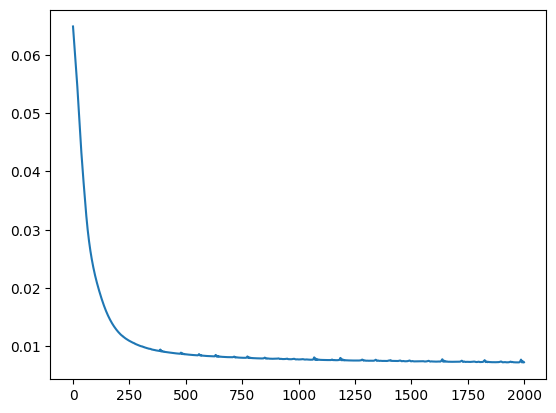

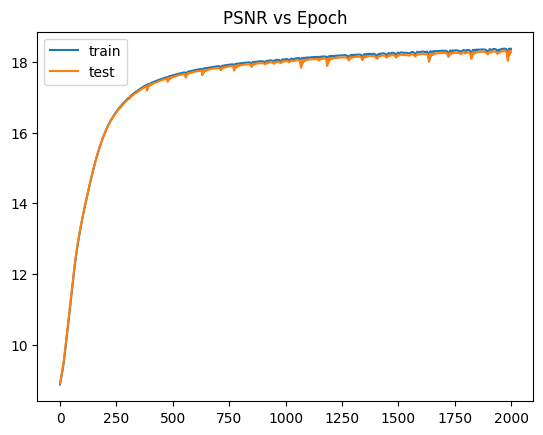

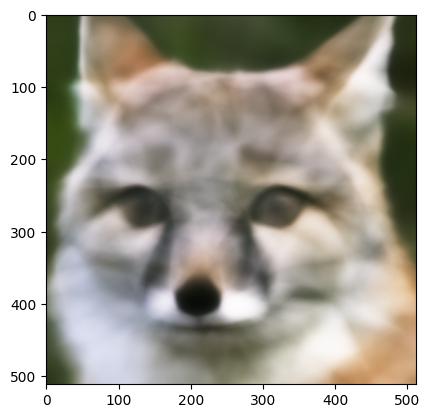

Epoch: 1 | loss: 0.0663030818104744 | train_psnr: 8.774362564086914 | test_psnr: 8.790925979614258
Epoch: 101 | loss: 0.01857144385576248 | train_psnr: 14.301243782043457 | test_psnr: 14.42309284210205
Epoch: 201 | loss: 0.006137753836810589 | train_psnr: 19.109607696533203 | test_psnr: 18.939990997314453
Epoch: 301 | loss: 0.004906903486698866 | train_psnr: 20.081626892089844 | test_psnr: 19.748695373535156
Epoch: 401 | loss: 0.004211331717669964 | train_psnr: 20.745506286621094 | test_psnr: 20.217275619506836
Epoch: 501 | loss: 0.0036300532519817352 | train_psnr: 21.39056968688965 | test_psnr: 20.594257354736328
Epoch: 601 | loss: 0.0030761014204472303 | train_psnr: 22.109695434570312 | test_psnr: 20.932743072509766
Epoch: 701 | loss: 0.0025843698531389236 | train_psnr: 22.866153717041016 | test_psnr: 21.216346740722656
Epoch: 801 | loss: 0.0021783486008644104 | train_psnr: 23.608427047729492 | test_psnr: 21.43299102783203
Epoch: 901 | loss: 0.0018496974371373653 | train_psnr: 24.318

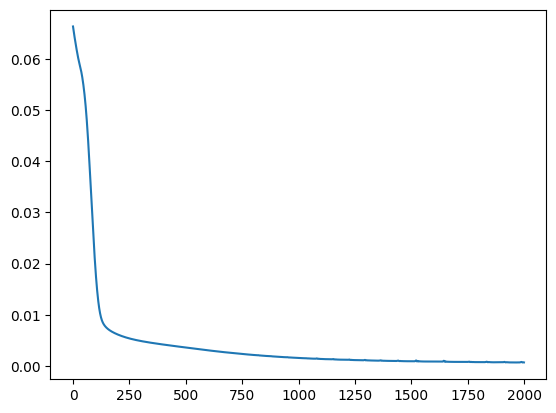

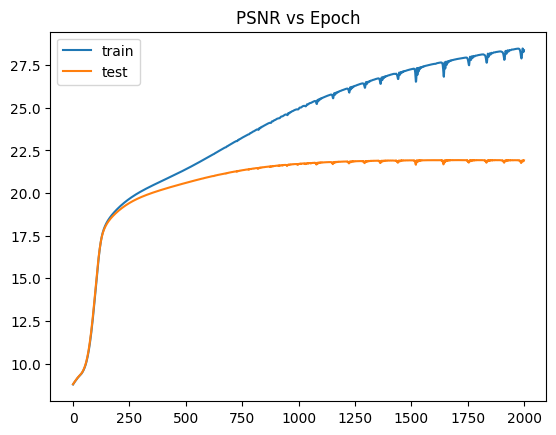

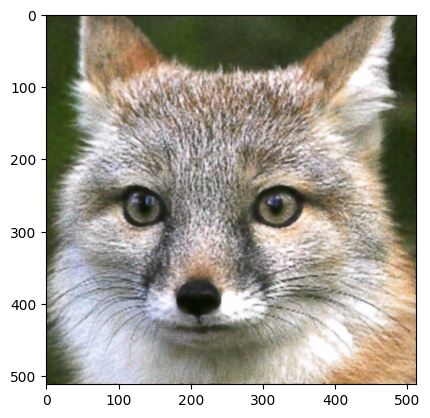

Epoch: 1 | loss: 0.06556637585163116 | train_psnr: 8.822888374328613 | test_psnr: 8.835433959960938
Epoch: 101 | loss: 0.059811320155858994 | train_psnr: 9.221866607666016 | test_psnr: 9.164604187011719
Epoch: 201 | loss: 0.02957926318049431 | train_psnr: 12.279827117919922 | test_psnr: 9.245013236999512
Epoch: 301 | loss: 0.005581600125879049 | train_psnr: 19.522111892700195 | test_psnr: 8.16846752166748
Epoch: 401 | loss: 0.0027732416056096554 | train_psnr: 22.55982208251953 | test_psnr: 7.817081451416016
Epoch: 501 | loss: 0.0021709336433559656 | train_psnr: 23.62323570251465 | test_psnr: 7.684452533721924
Epoch: 601 | loss: 0.0019517629407346249 | train_psnr: 24.085430145263672 | test_psnr: 7.6094536781311035
Epoch: 701 | loss: 0.0018461167346686125 | train_psnr: 24.32710838317871 | test_psnr: 7.557709693908691
Epoch: 801 | loss: 0.0017859432846307755 | train_psnr: 24.471023559570312 | test_psnr: 7.5207929611206055
Epoch: 901 | loss: 0.0017461590468883514 | train_psnr: 24.568862915

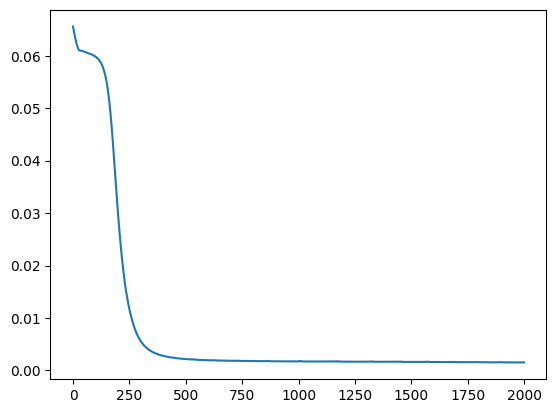

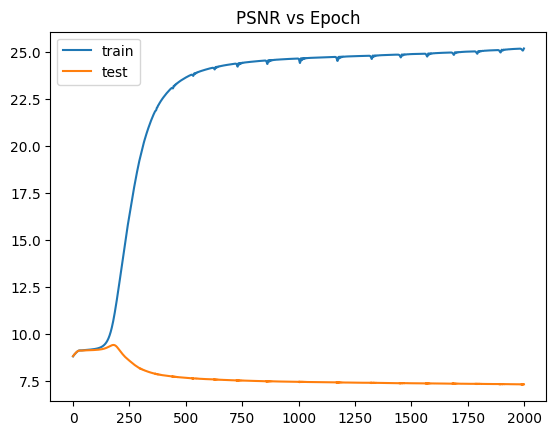

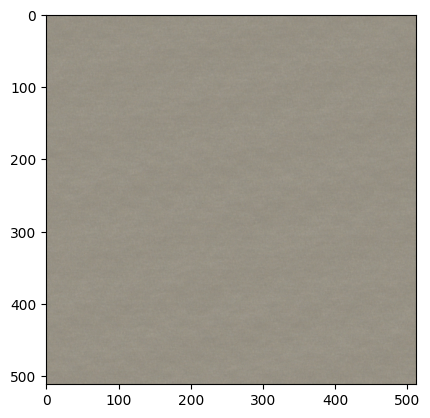

Optimal s = 10


In [ ]:
outputs = []

for s in [1, 10, 100]:
  model = FFMLP(s=s).to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  loss_fn = torch.nn.MSELoss()

  n_ckpt = 100

  def train():
    model.train()
    ops = []
    train_psnrs = []
    test_psnrs = []
    losses = []

    for epoch in range(num_epochs):

      optimizer.zero_grad()
      train_preds = model(train_inputs)
      loss = loss_fn(train_outputs, train_preds)

      loss.backward()
      losses.append(loss.item())
      optimizer.step()

      with torch.no_grad():
        train_psnrs.append(psnr(train_preds, train_outputs).cpu().numpy())
        test_preds = model(test_inputs)
        test_psnrs.append(psnr(test_preds, test_outputs).cpu().numpy())
        pred_img = test_preds.reshape(512, 512, 3).cpu().numpy()

        if (epoch)%n_ckpt==0:
          ops.append(pred_img)
          print(f"Epoch: {epoch+1} | loss: {loss.item()} | train_psnr: {train_psnrs[-1]} | test_psnr: {test_psnrs[-1]}")

    print()
    return ops, train_psnrs, test_psnrs, losses

  ops, train_psnrs, test_psnrs, losses = train()

  outputs.append(max(test_psnrs))

  import numpy as np
  max_idx = np.argmax(test_psnrs)
  best_op = ops[max_idx // n_ckpt]

  plt.plot(losses)
  plt.show()

  plt.plot(train_psnrs, label='train')
  plt.plot(test_psnrs, label='test')
  plt.title('PSNR vs Epoch')
  plt.legend()
  plt.show()

  plt.imshow(best_op)
  plt.show()

print(f"Optimal s = {[1, 10, 100][np.argmax(outputs)]}")